Epoch 20, Loss: 0.39436
Epoch 40, Loss: 0.29244
Epoch 60, Loss: 0.25178
Epoch 80, Loss: 0.23591
Epoch 100, Loss: 0.22701
Epoch 120, Loss: 0.22042
Epoch 140, Loss: 0.21505
Epoch 160, Loss: 0.21086
Epoch 180, Loss: 0.20783
Epoch 200, Loss: 0.20563
Epoch 220, Loss: 0.20391
Epoch 240, Loss: 0.20247
Epoch 260, Loss: 0.20127
Epoch 280, Loss: 0.20027
Epoch 300, Loss: 0.19938
Epoch 320, Loss: 0.19861
Epoch 340, Loss: 0.19795
Epoch 360, Loss: 0.19737
Epoch 380, Loss: 0.19685
Epoch 400, Loss: 0.19638
Epoch 420, Loss: 0.19597
Epoch 440, Loss: 0.19560
Epoch 460, Loss: 0.19526
Epoch 480, Loss: 0.19494
Epoch 500, Loss: 0.19464
Epoch 520, Loss: 0.19438
Epoch 540, Loss: 0.19415
Epoch 560, Loss: 0.19392
Epoch 580, Loss: 0.19371
Epoch 600, Loss: 0.19352
Epoch 620, Loss: 0.19334
Epoch 640, Loss: 0.19317
Epoch 660, Loss: 0.19299
Epoch 680, Loss: 0.19282
Epoch 700, Loss: 0.19270
Epoch 720, Loss: 0.19262
Epoch 740, Loss: 0.19241
Epoch 760, Loss: 0.19232
Epoch 780, Loss: 0.19218
Epoch 800, Loss: 0.19207
Epoc

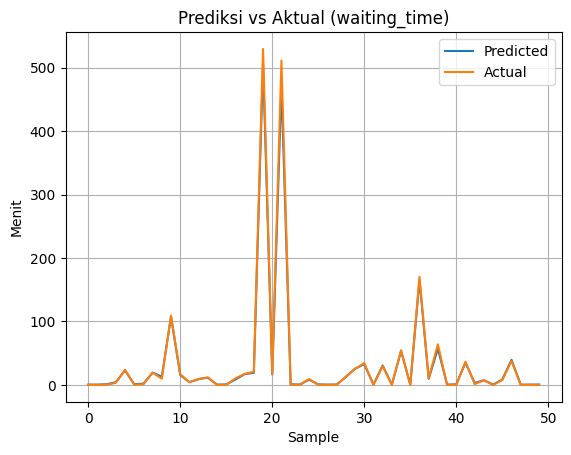

⏱️ Prediksi waktu tunggu: 5.03 menit


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ===================== 1. LOAD & PREPROCESS =====================

# Load data
df = pd.read_csv("../simulasi_queue/all_event_based_with_initial_q.csv")
df["Charging Rate"] = pd.to_numeric(df["Charging Rate"], errors="coerce")
df.dropna(inplace=True)

# Log transform target agar lebih stabil
df["waiting_time_log"] = np.log1p(df["waiting_time"] / df["count"])  # log(1 + x)

# Fitur dan label
X = df[["initial_q", "time", "Charging Rate", "arrival_rate", "service_rate", "s"]].values
y = df["waiting_time_log"].values.reshape(-1, 1)

# Normalisasi
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Convert ke tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# ===================== 2. DEFINE MODEL =====================

class WaitingTimeNN(nn.Module):
    def __init__(self):
        super(WaitingTimeNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # no ReLU at output
        )
    def forward(self, x):
        return self.model(x)

model = WaitingTimeNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ===================== 3. TRAINING LOOP =====================

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)

    # Penalti jika output negatif (optional)
    penalty = torch.mean(torch.clamp(-output, min=0)) * 0.5
    loss = loss_fn(output, y_train) + penalty

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")

# ===================== 4. EVALUASI & PLOT =====================

model.eval()
with torch.no_grad():
    pred_scaled = model(X_test).numpy()
    pred_log = scaler_y.inverse_transform(pred_scaled)
    pred_final = np.expm1(pred_log)  # balik dari log

    y_true_log = scaler_y.inverse_transform(y_test.numpy())
    y_true_final = np.expm1(y_true_log)

# Plot
plt.plot(pred_final[:50], label="Predicted")
plt.plot(y_true_final[:50], label="Actual")
plt.legend()
plt.title("Prediksi vs Aktual (waiting_time)")
plt.xlabel("Sample")
plt.ylabel("Menit")
plt.grid(True)
plt.show()

# ===================== 5. FUNGSI PREDIKSI MANUAL =====================

def predict_waiting_time(input_array):
    scaled = scaler_x.transform(input_array)
    tensor = torch.tensor(scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred_scaled = model(tensor).numpy()
        pred_log = scaler_y.inverse_transform(pred_scaled)
        return np.expm1(pred_log)  # inverse log1p

# Contoh input prediksi
manual_input = np.array([[1, 1999, 22, 0.0087, 0.3497, 1]])
hasil = predict_waiting_time(manual_input)
print(f"⏱️ Prediksi waktu tunggu: {hasil[0][0]:.2f} menit")


In [3]:
import pickle

# Simpan model dan scaler
save_path = "model_waiting_time.pkl"
model_data = {
    "model_state_dict": model.state_dict(),
    "scaler_x": scaler_x,
    "scaler_y": scaler_y
}

with open(save_path, "wb") as f:
    pickle.dump(model_data, f)

print(f"✅ Model dan scaler berhasil disimpan ke {save_path}")


✅ Model dan scaler berhasil disimpan ke model_waiting_time.pkl


In [12]:
# Load kembali model dan scaler
with open("model_waiting_time.pkl", "rb") as f:
    loaded = pickle.load(f)

# Inisialisasi model dan load state dict
model_loaded = WaitingTimeNN()
model_loaded.load_state_dict(loaded["model_state_dict"])
model_loaded.eval()

# Ambil scaler
scaler_x_loaded = loaded["scaler_x"]
scaler_y_loaded = loaded["scaler_y"]

# Contoh prediksi ulang
test_input = np.array([[1, 100, 22, 0.0233, 0.3497, 1]])
scaled = scaler_x_loaded.transform(test_input)
tensor = torch.tensor(scaled, dtype=torch.float32)
with torch.no_grad():
    pred = model_loaded(tensor).numpy()
    pred_final = np.expm1(scaler_y_loaded.inverse_transform(pred))
print(f"⏱️ Prediksi dari model terload: {pred_final[0][0]:.2f} menit")


⏱️ Prediksi dari model terload: 97.67 menit
